# UMAP plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark
from pyspark.sql import functions as F
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spark = get_spark()
display(spark)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/17 20:15:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/17 20:15:44 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/06/17 20:15:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data"
dct_emb_path = "process/training_cropped_resized_v2/dino_dct/data"
train_path = "parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the embedding files
dct_gcs_path = f"{gcs_path}/{dct_emb_path}"
train_gcs_path = f"{gcs_path}/{train_path}"

# Read the Parquet file into a DataFrame
dct_df = spark.read.parquet(dct_gcs_path)
train_df = spark.read.parquet(train_gcs_path)

# Show the data
dct_df.show(n=5, truncate=50)
train_df.show(n=5, truncate=50)

# CLS embeddings
cls_emb_path = "process/training_cropped_resized_v2/dino_cls_token/data"
cls_gcs_path = f"{gcs_path}/{cls_emb_path}"
cls_df = spark.read.parquet(cls_gcs_path)
cls_df.show(n=5, truncate=50)

# pretrained embeddings
pre_emb_path = "process/training_cropped_resized_v2/dino_pretrained/data"
pre_gcs_path = f"{gcs_path}/{pre_emb_path}"
pre_df = spark.read.parquet(pre_gcs_path)
pre_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                     dct_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|170e88ca9af457daa1038092479b251c61c64f7d.jpg|   1742956|[-20648.51, 2133.689, -2555.3125, 14820.57, 685...|
|c24a2d8646f5bc7112a39908bd2f6c45bf066a71.jpg|   1356834|[-25395.82, -12564.387, 24736.02, 20483.8, 2115...|
|e1f68e5f05618921969aee2575de20e537e6d66b.jpg|   1563754|[-26178.633, -7670.404, -22552.29, -6563.006, 8...|
|b0433cd6968b57d52e5c25dc45a28e674a25e61e.jpg|   1367432|[-23662.764, -6773.8213, -8283.518, 3769.6064, ...|
|96478a0fe20a41e755b0c8d798690f2c2b7c115f.jpg|   1389010|[-22182.172, -19444.006, 23355.23, 7042.8604, -...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

+--------------------------------------------+--------------------------------------------------+------+----------+----------+----------------------------------------------+-------+-------------------------------------+--------+-------------+-------------+---------------+--------------------------------------+----------+-------------+--------+-----------+--------------------------------------------------+--------------------------------------------------+---------+--------------------------------------------------+--------------------------------------------------+
|                                  image_name|                                              path| organ|species_id|    obs_id|                                       license|partner|                               author|altitude|     latitude|    longitude|gbif_species_id|                               species|     genus|       family| dataset|  publisher|                                        references|                    

In [4]:
from pyspark.sql import DataFrame


def prepare_emb_df(
    df: DataFrame, train_df: DataFrame, col_name: str, num_top_species: int = 5
):
    # Transformation
    grouped_df = (
        df.groupBy("species_id")
        .agg(F.count("species_id").alias("n"))
        .orderBy(F.col("n").desc())
    )
    # Get top species DF
    top_species = [
        int(row["species_id"]) for row in grouped_df.limit(num_top_species).collect()
    ]
    print(f"Top {num_top_species} species ids: {top_species}")

    subset_df = df.filter(F.col("species_id").isin(top_species)).select(
        ["image_name", "species_id", col_name]
    )

    subset_df = subset_df.join(train_df, "image_name", "inner").select(
        [subset_df.species_id, train_df.species, subset_df[col_name]]
    )
    return subset_df

In [5]:
# DCT dataframe
dct_sub_df = prepare_emb_df(
    df=dct_df, train_df=train_df, col_name="dct_embedding", num_top_species=5
)

# CLS dataframe
cls_sub_df = prepare_emb_df(
    df=cls_df, train_df=train_df, col_name="cls_embedding", num_top_species=5
)

# pretrained dataframe
pretrained_sub_df = prepare_emb_df(
    df=pre_df, train_df=train_df, col_name="cls_embedding", num_top_species=5
)

Top 5 species ids: [1369068, 1360257, 1737559, 1741625, 1414366]


Top 5 species ids: [1369068, 1360257, 1737559, 1741625, 1414366]


Top 5 species ids: [1369068, 1360257, 1737559, 1741625, 1414366]


In [6]:
from sklearn.preprocessing import StandardScaler


def get_pandas_embeddings(df: DataFrame, col_name: str):
    # Convert to Pandas DF
    pandas_df = df.select([col_name, "species"]).toPandas()

    # Extract features and labels
    emb_df = np.stack(pandas_df[col_name].values)
    scaled_emb = StandardScaler().fit_transform(emb_df)

    # UMAP reduction
    reducer = umap.UMAP(
        n_neighbors=15, n_components=2, metric="euclidean", random_state=42
    )
    embedding = reducer.fit_transform(
        scaled_emb
    )  # NumPy array with shape (n_samples, 2)
    return pandas_df, embedding, scaled_emb

In [7]:
# DCT embeddings
dct_pandas_df, dct_embedding, dct_scaled_emb = get_pandas_embeddings(
    df=dct_sub_df, col_name="dct_embedding"
)

# CLS embeddings
cls_pandas_df, cls_embedding, cls_scaled_emb = get_pandas_embeddings(
    df=cls_sub_df, col_name="cls_embedding"
)

# pretrained embeddings
pre_pandas_df, pre_embedding, pre_scaled_emb = get_pandas_embeddings(
    df=pretrained_sub_df, col_name="cls_embedding"
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs 

In [143]:
import os
from pathlib import Path


def plot_umap_clusters(
    pandas_df_list: list[pd.DataFrame],
    embedding_list: list[pd.DataFrame],
):
    # Plot the data
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=300)
    fig.suptitle(
        f"UMAP projection of top 5 plant species",
        fontsize=16,
        weight="bold",
    )

    titles = [
        "Image token DCT coefficient",
        "Vanilla CLS embeddings",
        "Pretrained CLS embeddings",
    ]

    for i, pandas_df in enumerate(pandas_df_list):
        # Create a scatter plot, color-coded by new species_idx
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
        top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
        species_to_color = {
            species: colors[i] for i, species in enumerate(top_species_idx)
        }
        # Map species IDs to colors for plotting
        color_list = pandas_df["species"].map(species_to_color).tolist()

        for species, color in species_to_color.items():
            # Select embeddings for the current species
            idx = pandas_df["species"] == species
            axes[i].scatter(
                embedding_list[i][idx, 0],
                embedding_list[i][idx, 1],
                c=color,
                # cmap="tab10",
                label=species,
                s=5,
                alpha=0.7,
                linewidth=0.5,
            )
        axes[i].set_title(f"{titles[i]}", fontsize=14)
        axes[i].grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
        # axes[i].legend(loc="best", title="Species Name", fontsize="small")
        for spine in ["top", "right", "bottom", "left"]:
            axes[i].spines[spine].set_visible(False)
    fig.tight_layout(pad=0.5)
    path = Path(os.getcwd()).parents[1]
    plt.savefig(f"{path}/figures/umap_cluster.png")
    plt.show()

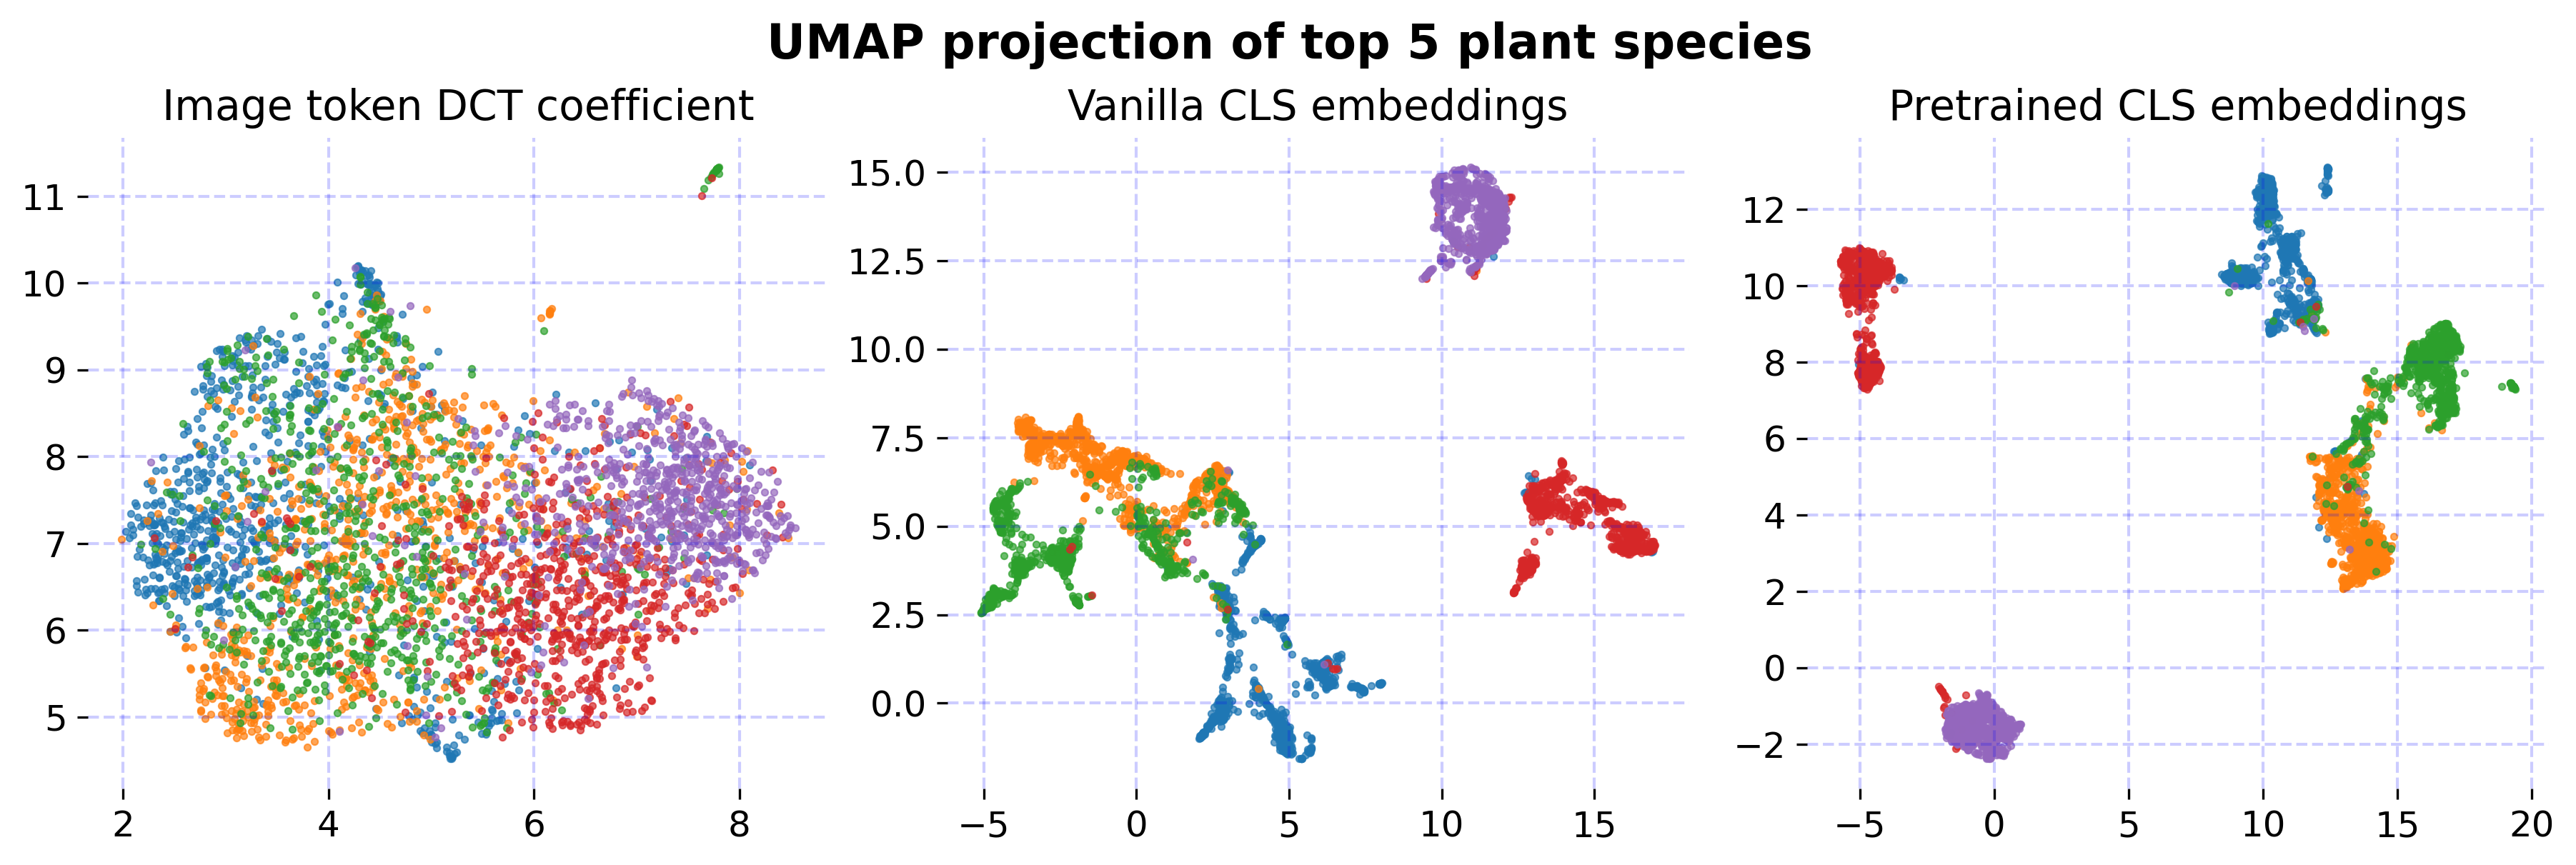

In [144]:
pandas_df_list = [dct_pandas_df, cls_pandas_df, pre_pandas_df]
embedding_list = [dct_embedding, cls_embedding, pre_embedding]
plot_umap_clusters(pandas_df_list, embedding_list)